In [2]:
%load_ext autoreload
%autoreload 2
%aimport -jax
%aimport -jaxlib

In [3]:
from stanza.reporting.local import LocalDatabase
from pathlib import Path

db = LocalDatabase(path=Path("../../results"))
data = db.open("expert_data/pendulum")
trajs = data.get("trajectories")
env_name = data.get("env_name")
import stanza.envs as envs
env = envs.create(env_name)

In [4]:
import jax
import jax.numpy as jnp

traj0 = trajs[1].data
from stanza.util.ipython import display_video
video = jax.vmap(env.render)(traj0.state)
display_video(video)

In [5]:
from stanza.util import extract_shifted

states_early, states_late = extract_shifted(traj0.observation)
actions = jax.tree_map(lambda x: x[:-1], traj0.action)
reward = jnp.sum(jax.vmap(env.reward)(states_early, actions, states_late))
print(f"Reward: {reward}")

Reward: 8.177294731140137


In [6]:
from stanza.data import PyTreeData
import jax.flatten_util
from jax.random import PRNGKey

data = PyTreeData.from_data(trajs.flatten()).shuffle(PRNGKey(42)).data
obs, actions, Ks = data.observation, data.action, data.info.K
flatten = jax.vmap(lambda x: jax.flatten_util.ravel_pytree(x)[0])
obs, actions = flatten(obs), flatten(actions)
obs, actions = obs[:300], actions[:300]

In [45]:
if env_name == "pendulum":
    import plotly.graph_objects as go
    fig = go.Figure()
    x, y, z= obs[:, 0], obs[:, 1], actions[:, 0]
    fig.add_trace(go.Scatter3d(x=x, y=y, z=z, mode="markers"))

    x, y = jnp.linspace(-3, 8, 10), jnp.linspace(-3, 8, 10)
    xs, ys = jnp.meshgrid(x, y)
    xs, ys = xs.reshape(-1), ys.reshape(-1)
    K, x0, z0 = Ks[0], obs[0], actions[0,0]
    z = jax.vmap(lambda x, y: jnp.squeeze(K @ (jnp.stack((x,y)) - x0) + z0))(xs, ys)
    z = z.reshape((x.shape[0], y.shape[0]))
    fig.add_trace(go.Surface(x=x, y=y, z=z, opacity=0.5))

    fig.update_layout(scene=dict(xaxis_title="angle", yaxis_title="vel", zaxis_title="action"))
    fig.show()


In [ ]:
exp = db.open("diffusion_policy/silver-star-356")
val_exp_data = exp.get("test_expert")
val_policy_data = exp.get("test_policy")

for i in range(1):
    exp_traj = jax.tree_map(lambda x: x[i], val_exp_data)
    pol_traj = jax.tree_map(lambda x: x[i], val_policy_data)
    video = jax.vmap(env.render)(pol_traj.states)
display_video(video)

In [95]:
import wandb
import pandas as pd
api = wandb.Api()
sweep = api.sweep("dpfrommer-projects/stanza/agp2315g")

data = []
for r in sweep.runs:
    if "test_reward" not in r.summary:
        continue
    d = {
        "num_traj": r.config["num_trajectories"],
        "lambda": r.config["regularize_gains_lambda"],
        "test_reward": r.summary["test_reward"],
    }
    data.append(d)
data = pd.DataFrame(data)
print(data)

    num_traj  lambda  test_reward
0         25   0.005     0.332065
1         25   0.001     0.166418
2         25   0.000     0.203019
3         20   1.000     0.321177
4         20   0.500     0.600153
5         20   0.100     0.409215
6         20   0.050     0.224351
7         20   0.010     0.198773
8         20   0.005     0.087526
9         20   0.001     0.105438
10        20   0.000     0.089347
11        15   1.000     0.305723
12        15   0.500     0.654151
13        15   0.100     0.287029
14        15   0.050     0.342337
15        15   0.010     0.131055
16        15   0.005     0.101466
17        15   0.001     0.085843
18        15   0.000     0.092091
19        10   1.000     0.375682
20        10   0.500     0.493940
21        10   0.100     0.272336
22        10   0.050     0.181033
23        10   0.010     0.094147
24        10   0.005     0.054419
25        10   0.001     0.027284
26        10   0.000     0.001692
27         5   1.000     0.255115
28         5  

In [82]:
import matplotlib.pyplot as plt
import seaborn as sns
colors = sns.color_palette("Set2")
colors_dark = [(0.8*r, 0.8*g, 0.8*b) for (r,g,b) in colors]
#colors = [f'rgb({int(r*255)},{int(g*255)},{int(b*255)})' for (r,g,b) in colors]
#colors_dark = [f'rgb({int(r*255)},{int(g*255)},{int(b*255)})' for (r,g,b) in colors_dark]
markers = ["circle", "square", "triangle-up", "diamond", "cross"]
styles = list(zip(zip(colors,markers), zip(colors_dark,markers)))
sns.set_theme(style="darkgrid")

def plot(data, x, ys, consolidate=[], style_func=lambda series, y: {}):
  # average over the ys
  groupby = list(set(data.columns) - set(ys) - set(consolidate))
  groups = data.groupby(groupby, group_keys=True)
  mean = groups.mean().reset_index()
  std = groups.std().reset_index()
  # group mean, std by things that are not
  # x or ys
  groupby = list(set(data.columns) - set([x] + ys + consolidate))
  mean = mean.groupby(groupby, group_keys=True).apply(lambda x: x)
  std = std.groupby(groupby, group_keys=True).apply(lambda x: x)

  color_iter = iter(zip(colors, colors_dark))
  for (series, m), (_, s) in zip(mean.groupby(level=0),std.groupby(level=0)):
    x_vals = m[x].to_numpy()
    sub_colors = next(color_iter)
    for y, c in zip(ys, sub_colors):
      y_vals = m[y].to_numpy()
      y_err_vals = s[y].to_numpy()

      plt.plot(x_vals, y_vals, color=c, **style_func(series, y))
      plt.fill_between(x_vals, y_vals - y_err_vals, y_vals + y_err_vals, color=c, alpha=0.2)
  plt.legend()

Text(0, 0.5, 'normalized reward')

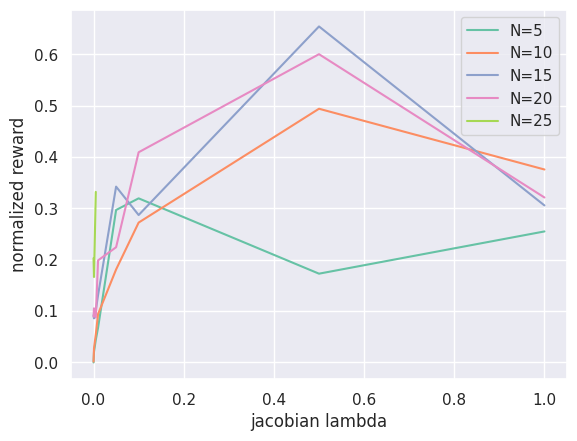

In [97]:
def style(series, y):
    return {
        "label": f"N={series}",
    }
filtered_data = data[data["lambda"] < 0.6]
plot(filtered_data, "lambda", ["test_reward"], style_func=style)
plt.xlabel("jacobian lambda")
plt.ylabel("normalized reward")